In [267]:
# Set Up
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [409]:
# Helper Functions for displaying image and scaling

def scale_img(img, scale_percent):
    print("\nscale_img()")
    print(img.shape)
    # Scale down image
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    print(img.shape)
    return img

# show grayscale image
def show_grayscale( my_image ):
    plt.figure(figsize = (10,10))
    plt.imshow(my_image, cmap = plt.get_cmap(name = 'gray'))
    plt.show()
    
def concat_horiz(img1, img2):
    vis = np.concatenate((img1, img2), axis=1)
    show_grayscale(vis)
    return vis

In [400]:
# computer gradient using sobel
def get_gradient(img):
    print("\nget_gradient()")
    padding = 1
    (y,x) = img.shape
    Ix = np.zeros(img.shape)
    Iy = np.zeros(img.shape)
    
    print("before padding:\t",img.shape)
    padded_img = np.pad(img, padding)
    print("after padding:\t",padded_img.shape)
    
    horiz = np.array([[-1, 0, 1]])
    vert  = np.array([[-1], [0], [1]])

    #print(padded_img[int(x)][int(y)])
    
    # Filter the image using sobel
    # Iterate across rows, then columns, computing gradient, remember this image is padded!
    for j in range( padding, padding + int(y)):
        for i in range( padding, padding + int(x)):
            #print(j, i)
            # Horizontal Gradient
            Ix[j-padding, i-padding] = horiz[0,0]*padded_img[j,i-1] + horiz[0, 1]*padded_img[j, i] + horiz[0, 2]*padded_img[j, i+1]
            # Vertical Gradient
            Iy[j-padding, i-padding] = vert[0]*padded_img[j-1, i]  + vert[1]*padded_img[j, i]  + vert[2]*padded_img[j+1, i]
    return (Ix, Iy)

In [270]:
# compute magnitude and angle of given gradients
# TODO rename this to something better
def get_arrows(Ix, Iy):
    print("\nget_arrows()")
    magnitude = 0
    angle = 1
    (y,x) = Ix.shape
    sub_matrix = np.zeros((y,x,2))
    
    for j in range( 0, int(y)):
        for i in range( 0, int(x)):
            #print(j, i)
            # compute magnitude
            sub_matrix[j,i,magnitude] = np.sqrt(Ix[j,i]**2 + Iy[j,i]**2)
            # compute angles
            sub_matrix[j,i,angle] = np.arctan2(Ix[j,i], Iy[j,i]) * 180 / np.pi
    return sub_matrix

In [470]:
# detect key points using openCV FAST or SURF
# Limit # of detected Kepoints <= 100
def get_kp( img, Suppress = False, Value = 0):
    print("\nget_kp()")
    print(type(img))
    print(img.shape)

    # Initiate FAST object with default values
    fast = cv.FastFeatureDetector_create()
    fast.setThreshold(100)
    
    # Disable nonmaxSuppression
    if (Suppress == False):
        fast.setNonmaxSuppression(Value)
    
    # find and draw the keypoints
    kp = fast.detect(img,None)
    # KP structure documentation: https://docs.opencv.org/master/d2/d29/classcv_1_1KeyPoint.html
    
    kp_img = cv.drawKeypoints(img, kp, None, color=(255,0,0))
    
    # Print all default params
    print( "\nThreshold: {}".format(fast.getThreshold()) )
    print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
    print( "neighborhood: {}".format(fast.getType()) )
    print( "Total Keypoints {}".format(len(kp)) )
    
    # print image
    show_grayscale(kp_img)
    
    return (kp, kp_img)

In [507]:
def draw_concat_kp(img, kp, kp_t, matches):
    copy = img
    for i in range(0, len(matches)):
        if matches[i] != 0:
            y1 = kp[i].pt[0]
            y2 = 2*kp_t[matches[i]].pt[0]
            x1 = kp[i].pt[1]
            x2 = kp_t[matches[i]].pt[1]
            copy = cv.line(copy, (int(y1),int(x1)), (int(y2),int(x2)), (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)) , 2)

    show_grayscale(copy)

In [508]:
# Gets 5x5 window extraction around a given keypoint data structure
def get_5x5_window( image, this_kp, padding = 0):
    #print("get_5x5_window()")
    padded_img = np.pad(image, padding)
    fd_window = np.zeros((5,5))
    
    (x, y) = this_kp.pt
    #print(this_kp.pt)
    #print(padded_img[int(x)][int(y)])
    
    # gather raw pixel data around kp coordinate
    for j in range( padding + int(y) - 2, padding + int(y) + 3):
        for i in range( padding + int(x) - 2, padding + int(x) + 3):
            #print(i,j)
            #print(padded_img[i][j])
            fd_window[j%(padding + int(y) - 2), i%(padding + int(x) - 2)] = padded_img[j, i]

    #print(fd_window)
    return fd_window

In [509]:
# returns vector of 5x5 windows for a given image
def get_fdvector_5x5(img, kp_list):
    print("\nget_fdvector_5x5()")
    fd_vector = []
    
    for kp in kp_list:
        fd_vector.append(get_5x5_window(img, kp))
        
    # creates 3D matrix of fd windows
    fd_vector = np.stack(fd_vector, axis=0)
    
    print(fd_vector.shape)
    return fd_vector

In [510]:
def get_differences(fd_window, fd_vector):
    print("\nget_differences()")
    diff_vector = []
    
    for fd in fd_vector:
        diff_vector.append(np.subtract(fd_window, fd))

    # creates 3D matrix of fd windows
    diff_vector = np.stack(diff_vector, axis=0)
    
    print(diff_vector.shape)
    return diff_vector

In [511]:
def get_euclidean_distances(matrix_vector):
    print("\nget_euclidean_distance()")
    (y,x) = matrix_vector[0].shape
    euclidean_vector = []
    
    for matrix in matrix_vector:
        euclidean_vector.append(np.square(np.sum(np.square(matrix))))

    euclidean_vector = np.stack(euclidean_vector, axis=0)
                                
    print(euclidean_vector.shape)
    return euclidean_vector

In [512]:
def get_matching_fd( distances, ratio_threshold):
    # Set Up
    print("\nget_matching_fd()")
    copy = distances
    #print("size:\t",copy.shape)
    min1  = np.amin(copy)
    copy = copy[copy != min1]
    #print("size:\t",copy.shape)    
    min2 = np.amin(copy)
    copy = copy[copy != min2]
    #print("size:\t",copy.shape)
    ratio = min1/min2
    
    while(len(copy) > 1):
        #print("size:\t",copy.shape)
        if( ratio < ratio_threshold):
            return min1
        else:
            min1 = min2
            min2 = np.amin(copy)
            ratio = min1/min2
            copy = copy[copy != min2]
        
    # -1 marks a failure, kp should be removed by user
    return -1

In [513]:
# returns index of most likely match to keypoint kp in kp_list
def get_matching_kp_index(fd_window, fd_vector):
    # Compute distance matrices
    differences = get_differences(fd_window, fd_vector)
    # compute euclidean distances
    # find match
    return matching_kp



scale_img()
(682, 1416)
(170, 354)

get_kp()
<class 'numpy.ndarray'>
(170, 354)

Threshold: 100
nonmaxSuppression:True
neighborhood: 2
Total Keypoints 15


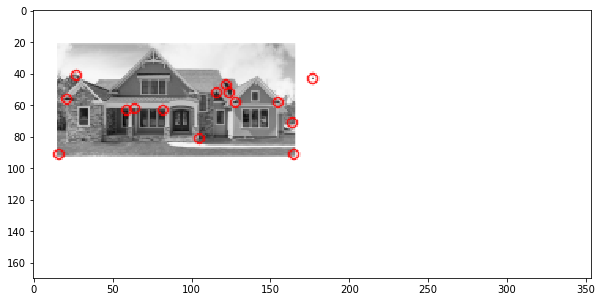


scale_img()
(682, 1416)
(170, 354)

get_kp()
<class 'numpy.ndarray'>
(170, 354)

Threshold: 100
nonmaxSuppression:True
neighborhood: 2
Total Keypoints 16


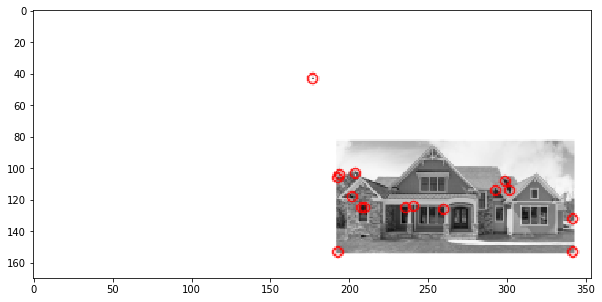

In [514]:
# image is a 2D numpy.ndarray
img = np.array(Image.open( 'House.png').convert('L'))
#img = np.array(Image.open( 'Square.png').convert('L'))

img = scale_img(img, 25)
kp, img_kp  = get_kp(img, Suppress=True, Value = 0)

img_t = np.array(Image.open( 'House_translation.png').convert('L'))
#img_t = np.array(Image.open( 'Square_translation.png').convert('L'))

img_t = scale_img(img_t, 25)
kp_t, img_kp_t  = get_kp(img_t, Suppress=True, Value = 0)

In [515]:
# Get Feature Descriptor 5 X 5
# Test on translated image, use Paint to create a Box, then move the box to the right

# build 5x5 window vector

# original image fd vector
fd_vector = get_fdvector_5x5(img, kp)
print("length of fd vector: \t\t",len(fd_vector))

# translated image fd vector
fd_vector_t = get_fdvector_5x5(img_t, kp_t)
print("length of fd vector translated: ",len(fd_vector_t))


get_fdvector_5x5()
(15, 5, 5)
length of fd vector: 		 15

get_fdvector_5x5()
(16, 5, 5)
length of fd vector translated:  16


In [516]:
# compute matching 5x5

matches = []
# sweep between original and translated image fd vectors
# example, finding most likely point for the first kp in the original image
for fd in fd_vector:
    differences = get_differences(fd, fd_vector_t)
    distances   = get_euclidean_distances(differences)
    
    # get matching point
    match = get_matching_fd( distances, ratio_threshold= 0.9)
    print(match)
    # get index of matching point
    index = np.where(distances==match)[0][0]
    print(index)
    matches.append(index)


get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
1067394241.0
1

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
0.0
0

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
65124900.0
4

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
206669376.0
5

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
3993481636.0
6

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
3814668169.0
7

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
4323720025.0
7

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
3948488569.0
1

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
100681156.0
8

get_differences()
(16, 5, 5)

get_euclidean_distance()
(16,)

get_matching_fd()
426752964.0
11

get_differences()
(16, 5, 5)

get_euclidean_distance

[1, 0, 4, 5, 6, 7, 7, 1, 8, 11, 11, 13, 4, 14, 15]


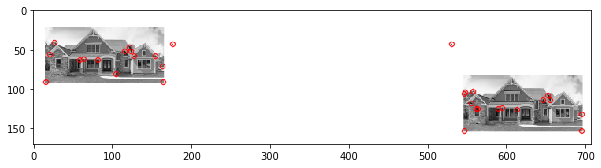

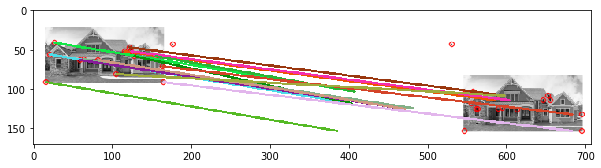

In [517]:
# our indexes for matching kps in the translated image.
print(matches)

#horizontal concatenation
concat_img = concat_horiz(img_kp, img_kp_t)

# draw kps on concat image
draw_concat_kp(concat_img, kp, kp_t, matches)

In [518]:
# compute matching 16x16

#get gradient of original image
(Ix, Iy) = get_gradient(img)
# get magnitudes and angles of original image
sub_matrix = get_arrows(Ix, Iy)
#for j in range( 0, sub_matrix.shape[0]):
    #for i in range( 0, sub_matrix.shape[1]):
        #print(sub_matrix[j,i])


get_gradient()
before padding:	 (170, 354)
after padding:	 (172, 356)

get_arrows()


In [228]:
# Implement SIFT like feature descriptor
# no orientation normalization if no rotation is involved